In [2]:
df = pd.read_csv('/home/billbrod/Data/spatial_frequency_preferences/derivatives/tuning_curves_summary/stim_class_5_blanks/posterior/v1-2-3_e1-12_eccen_bin_hemi_bin_tuning_curves_summary.csv')

In [17]:
df.columns

Index([u'varea', u'eccen', u'amplitude_estimate', u'stimulus_superclass',
       u'freq_space_angle', u'baseline', u'frequency_type', u'frequency_value',
       u'fit_warning', u'high_half_max', u'inf_warning', u'low_half_max',
       u'maxfev', u'mode_bound_lower', u'mode_bound_upper',
       u'preferred_period', u'tol', u'tuning_curve_amplitude',
       u'tuning_curve_bandwidth', u'tuning_curve_mu', u'tuning_curve_peak',
       u'tuning_curve_sigma', u'atlas_type', u'df_mode', u'mat_type',
       u'session', u'subject', u'task', u'tuning_curve_peak_octaves'],
      dtype='object')

{'varea': 1, 'session': ['ses-01', 'ses-02'], 'subject': ['sub-wlsubj001', 'sub-wlsubj045', 'sub-wlsubj042'], 'task': 'task-sfp'}
{}
{}
{}
[]


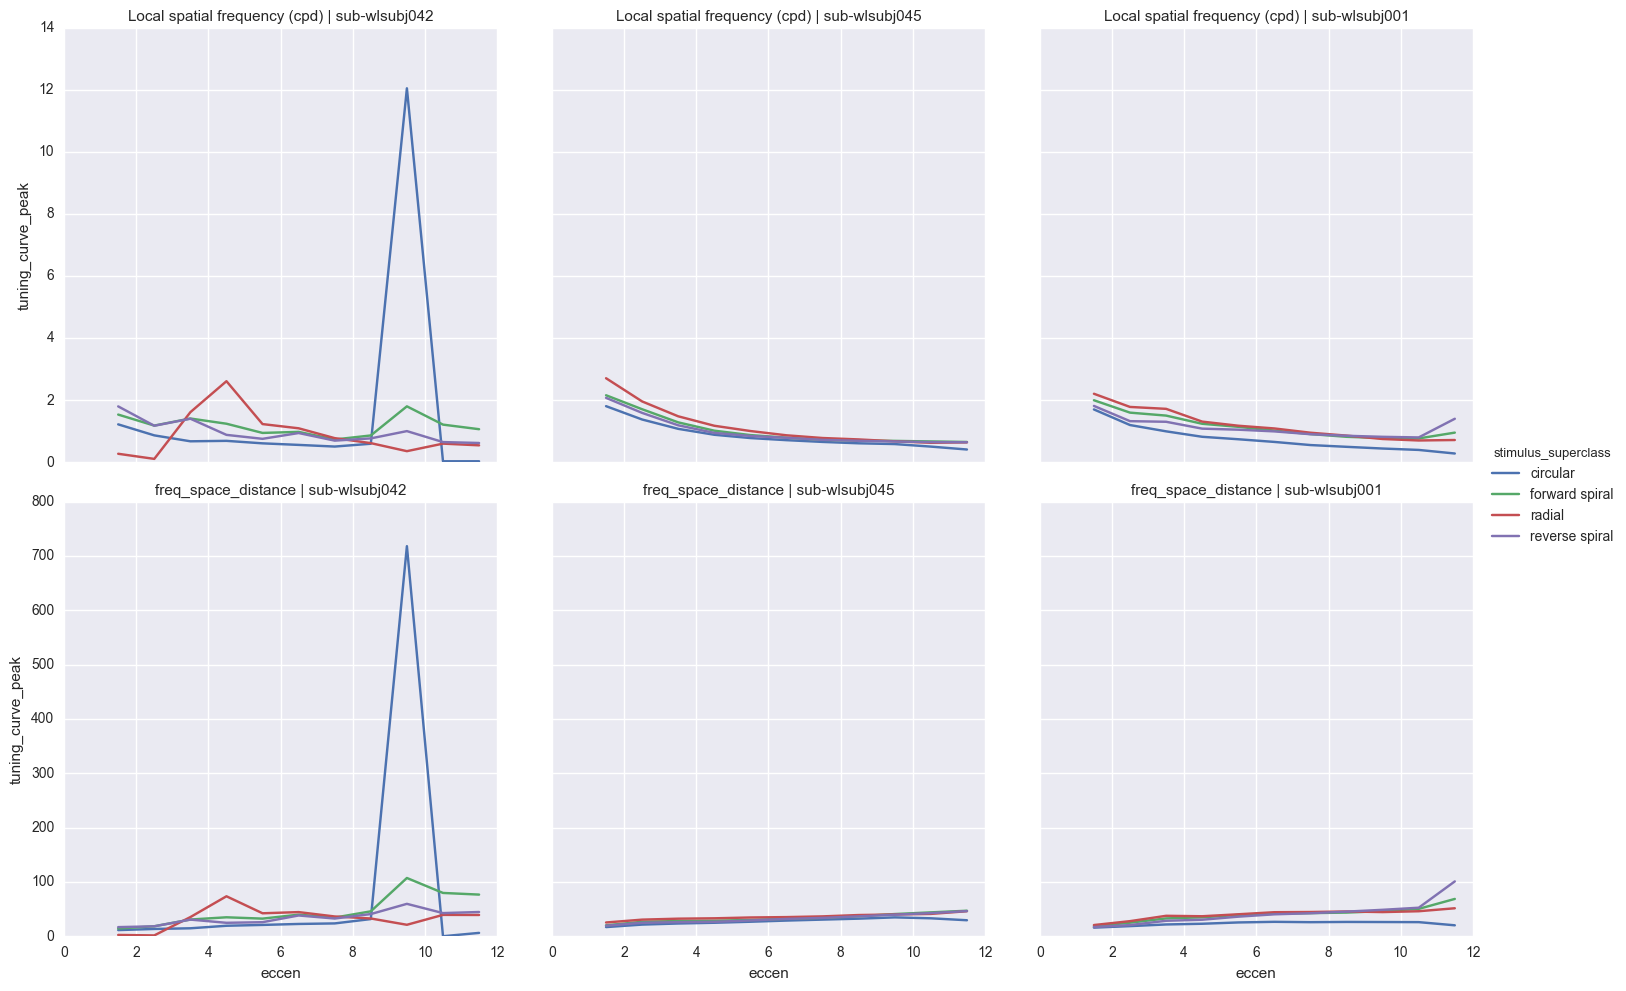

In [34]:
sfp.summary_plots.main(df, col='subject', y='tuning_curve_peak', session=['ses-01', 'ses-02'], task='task-sfp', varea=1, subject=['sub-wlsubj001', 'sub-wlsubj045', 'sub-wlsubj042'],)# plot_func=sns.plt.loglog, basey=2, basex=2)

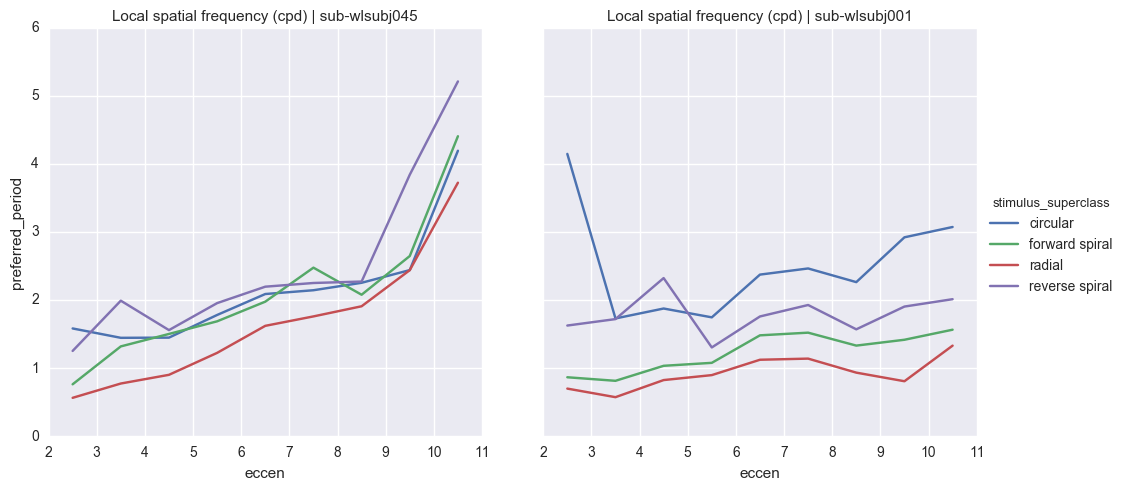

In [15]:
sfp.summary_plots.main(df, col='subject', y='preferred_period', session=['ses-01', 'ses-02'], task='task-sfp', varea=3, subject=['sub-wlsubj001', 'sub-wlsubj045'], frequency_type='Local spatial frequency (cpd)', eccen_range=(2, 11))

In [54]:
varea = nib.load('/mnt/Acadia/Freesurfer_subjects/wl_subj042/surf/lh.inferred_varea.mgz')
varea = np.array(varea.dataobj).reshape(max(varea.shape))
all_vis = nib.load('/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/GLMdenoise_reoriented/all_visual/sub-wlsubj042/ses-02/lh.sub-wlsubj042_ses-02_task-sfp_R2.mgz')
all_vis = np.array(all_vis.dataobj).reshape(max(all_vis.shape))

stim_class = nib.load('/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/GLMdenoise_reoriented/stim_class/sub-wlsubj042/ses-02/lh.sub-wlsubj042_ses-02_task-sfp_R2.mgz')
stim_class = np.array(stim_class.dataobj).reshape(max(stim_class.shape))

all_vis = all_vis[np.where(((varea==1)|(varea==2)|(varea==3)))]
stim_class = stim_class[np.where(((varea==1)|(varea==2)|(varea==3)))]

In [55]:
print(np.sum(all_vis > stim_class) / float(len(all_vis)))

0.0075543748962311145


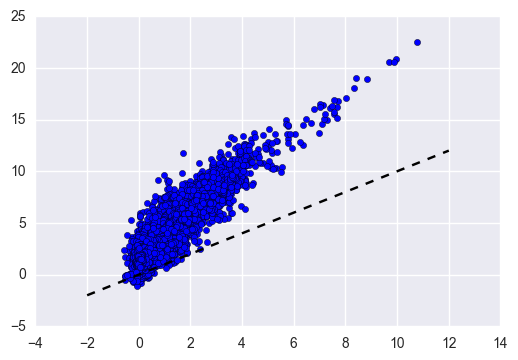

In [56]:
sns.plt.scatter(all_vis, stim_class)
sns.plt.plot([-2, 12], [-2, 12], 'k--')

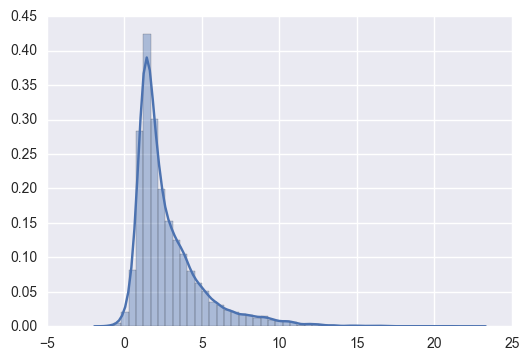

In [57]:
sns.distplot(stim_class)

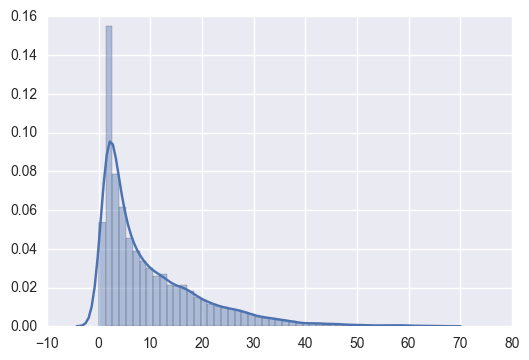

In [58]:
varea = nib.load('/mnt/Acadia/Freesurfer_subjects/wl_subj045/surf/lh.inferred_varea.mgz')
varea = np.array(varea.dataobj).reshape(max(varea.shape))
stim_class = nib.load('/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/GLMdenoise_reoriented/stim_class/sub-wlsubj045/ses-02/lh.sub-wlsubj045_ses-02_task-sfp_R2.mgz')
stim_class = np.array(stim_class.dataobj).reshape(max(stim_class.shape))

stim_class = stim_class[np.where(((varea==1)|(varea==2)|(varea==3)))]

sns.distplot(stim_class)

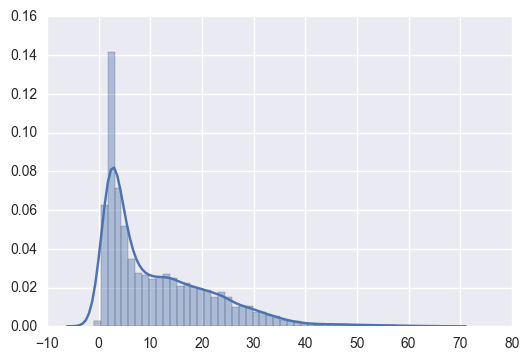

In [59]:
varea = nib.load('/mnt/Acadia/Freesurfer_subjects/wl_subj001/surf/lh.inferred_varea.mgz')
varea = np.array(varea.dataobj).reshape(max(varea.shape))
stim_class = nib.load('/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/GLMdenoise_reoriented/stim_class/sub-wlsubj001/ses-01/lh.sub-wlsubj001_ses-01_task-sfp_R2.mgz')
stim_class = np.array(stim_class.dataobj).reshape(max(stim_class.shape))

stim_class = stim_class[np.where(((varea==1)|(varea==2)|(varea==3)))]

sns.distplot(stim_class)

# Analyzing the first-level results

After running our GLM analysis, we have the estimated amplitude responses of each voxel to each image class. Along with Noah Benson's anatomical template / Bayesian model, we also have each voxel's visual area and location in the visual field (in terms of eccentricity and polar angle). By combining the information contained within them, along with the dataframe describing each stimulus class, we can construct our tuning curves.

In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import h5py
import os
import itertools
import pyPyrTools.JBhelpers as jbh
import pyPyrTools as ppt
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap 

/home/billbrod/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [16]:
# d = sfp.utils.load_data('wlsubj001', 'pilot01', atlas_type='prior', df_mode='full')
ds = sfp.utils.load_data('wlsubj045', 'ses-02', atlas_type='posterior', df_mode='summary',mat_type='stim_class_5_blanks')
# ds2 = sfp.utils.load_data('wlsubj001', 'ses-pilot01', atlas_type='prior', df_mode='summary',mat_type='stim_class')

In [83]:
tuning_df = ds['tuning_df']
tuning_df = tuning_df.drop_duplicates(['varea', 'eccen', 'stimulus_superclass', 'frequency_type'])
tuning_df = tuning_df.assign(subject='sub-wlsubj001', session='ses-pilot01', atlas_type='prior')
tuning_df['eccen'] = tuning_df.eccen.apply(lambda x: np.mean([float(i) for i in x.split('-')]))
tuning_df = tuning_df.reset_index(drop=True)
tuning_df['tuning_curve_peak'] = np.log2(tuning_df.tuning_curve_peak)

In [66]:
melted_df = pd.melt(tuning_df, ['varea', 'eccen', 'stimulus_superclass', 'frequency_type', 'subject', 'session', 'atlas_type'], ['preferred_period','tuning_curve_peak'])

In [67]:
tuning_df.head()

varea  eccen  amplitude_estimate stimulus_superclass  freq_space_angle  \
0      1    1.5            2.519578            circular          0.000000   
1      1    1.5            2.519578            circular          0.000000   
2      1    1.5            1.936041      forward spiral          0.785398   
3      1    1.5            1.936041      forward spiral          0.785398   
4      1    1.5            2.242023              radial          1.570796   

   baseline                 frequency_type  frequency_value  fit_warning  \
0 -0.128583  Local spatial frequency (cpd)         0.636906        False   
1 -0.128583            freq_space_distance         6.000000        False   
2 -0.128583  Local spatial frequency (cpd)         0.600481        False   
3 -0.128583            freq_space_distance         5.656854        False   
4 -0.128583  Local spatial frequency (cpd)         0.636906        False   

   high_half_max      ...        preferred_period           tol  \
0      13.781613      ...                0.588126  1.500000e-08   
1     129.846905      ...                0.062430  1.500000e-08   
2      12.241117      ...                0.500885  1.500000e-08   
3     115.334323      ...                0.053169  1.500000e-08   
4      13.451283      ...                0.453409  1.500000e-08   

   tuning_curve_amplitude  tuning_curve_bandwidth  tuning_curve_mu  \
0                2.882841                6.038318         3.689608   
1                2.882841                6.038335         5.932500   
2                2.987127                5.232327         3.063423   
3                2.987128                5.232327         5.306314   
4                3.132297                5.217326         3.149519   

   tuning_curve_peak  tuning_curve_sigma  atlas_type      session  \
0           0.765803            1.777300       prior  ses-pilot01   
1           4.001613            1.777300       prior  ses-pilot01   
2           0.997449            1.540144       prior  ses-pilot01   
3           4.233259            1.540144       prior  ses-pilot01   
4           1.141116            1.535760       prior  ses-pilot01   

         subject  
0  sub-wlsubj001  
1  sub-wlsubj001  
2  sub-wlsubj001  
3  sub-wlsubj001  
4  sub-wlsubj001  

[5 rows x 25 columns]

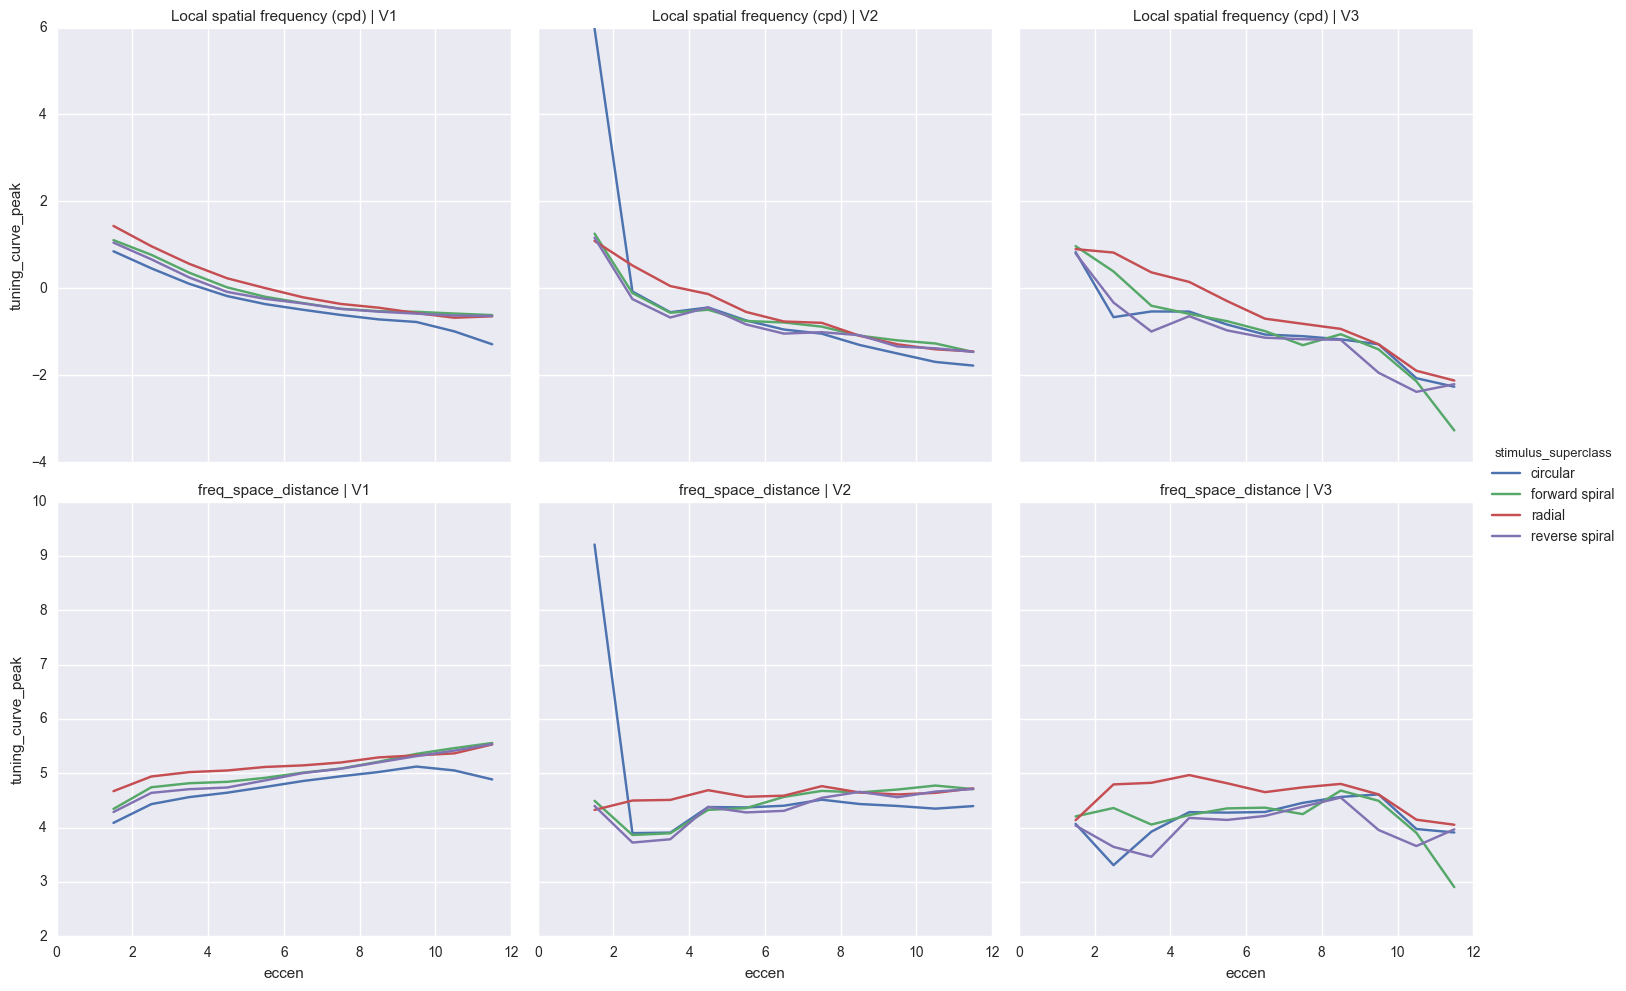

In [92]:
g = sns.FacetGrid(tuning_df, 'frequency_type', 'varea', hue='stimulus_superclass', aspect=1, size=5, sharey='row')
g.map(sns.plt.plot, 'eccen', 'tuning_curve_peak')
g.set_titles("{row_name} | V{col_name}")
g.add_legend()

Here we see the different stimulus classes, as plotted in frequency space, colored by their superclass. These numbers are roughly log-spaced (doubling).

We also, in order to double-check some of our calculations, plot the distance and angle in frequency space: they look exactly correct.

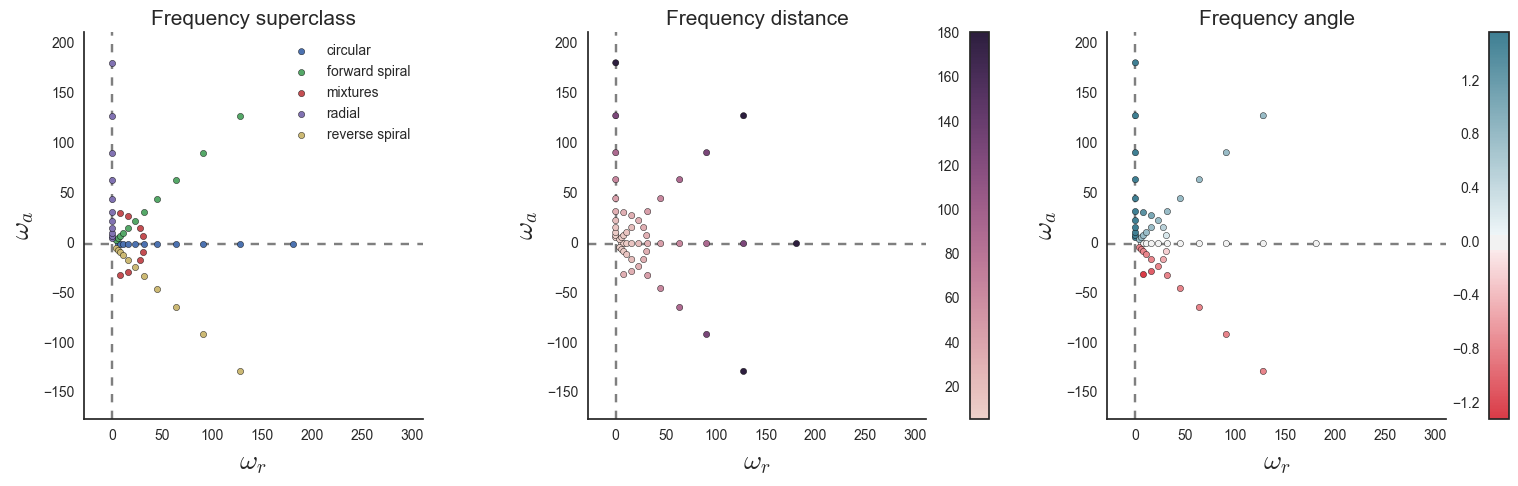

In [8]:
sfp.plotting.stimuli_properties(ds['df'])

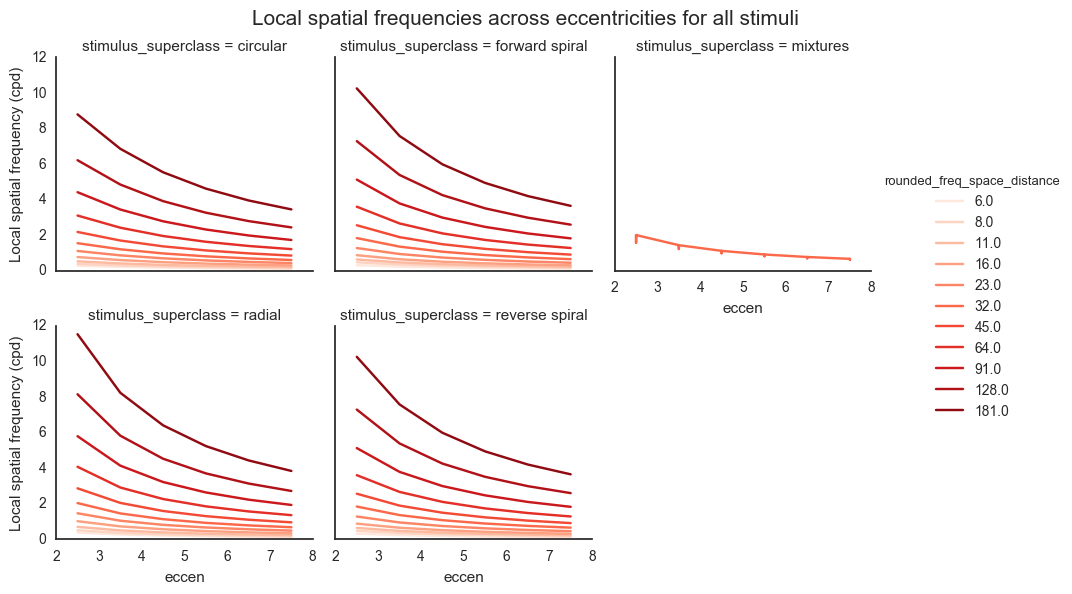

In [9]:
sfp.plotting.local_spatial_frequency(ds['df'])

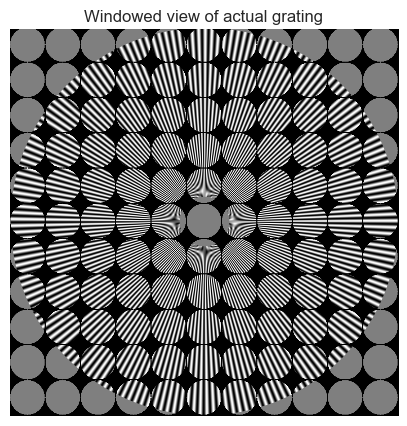

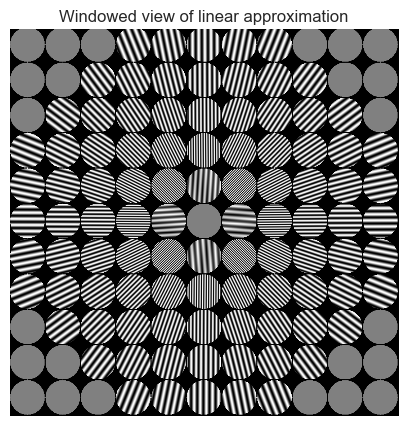

In [19]:
_ = sfp.plotting.stimuli_linear_approximation(d['stim'], d['stim_df'], d['stim_type'], 11, freq_space_distance=181, phi=np.pi/4, stimulus_superclass='radial', save_path='test.svg')

In [5]:
Rmin, Rmax = sfp.first_level_analysis.find_ecc_range_in_degrees(stim[0,:,:], 12)
print("Inside radius of stimulus annulus: %.02f" % Rmin)
print("Outside radius of stimulus annulus: %.02f" % Rmax)

Inside radius of stimulus annulus: 0.96
Outside radius of stimulus annulus: 12.00


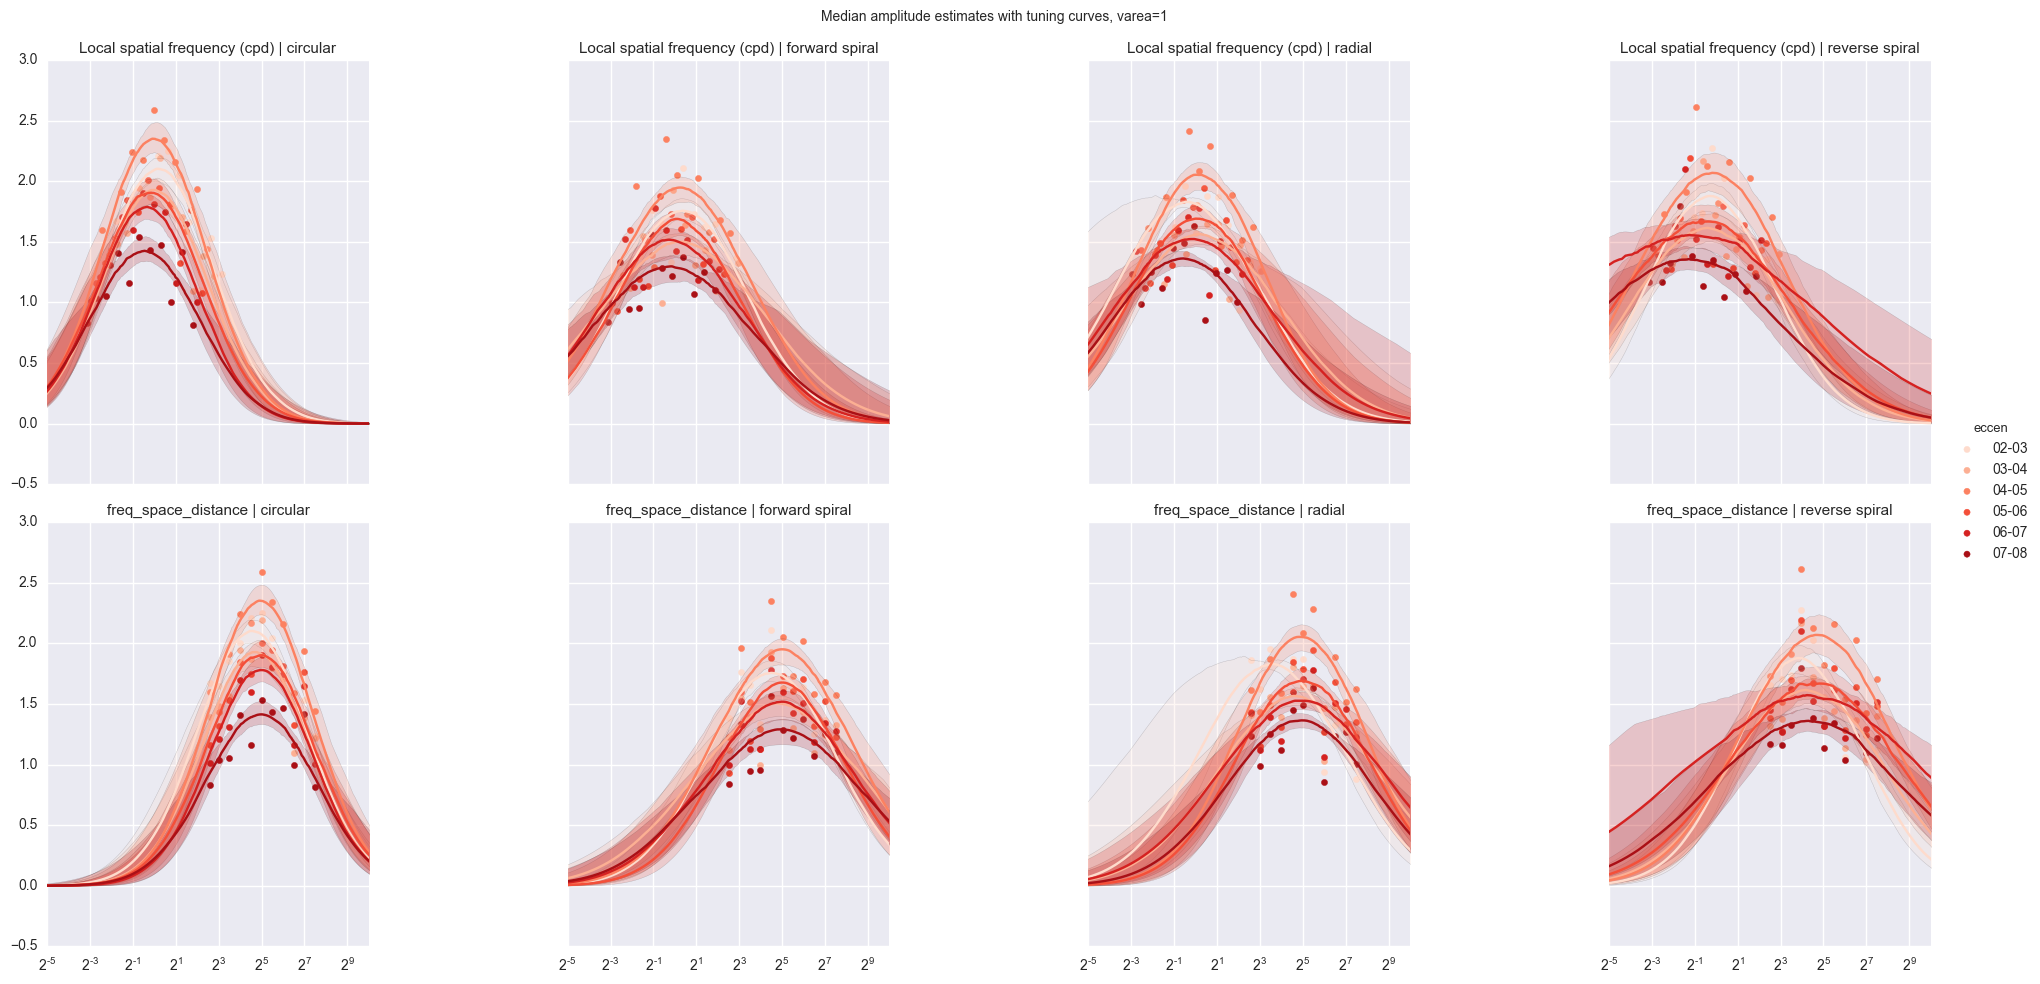

In [9]:
sfp.plotting.check_hypotheses_with_data(d['tuning_df'], 'test_%s.svg')

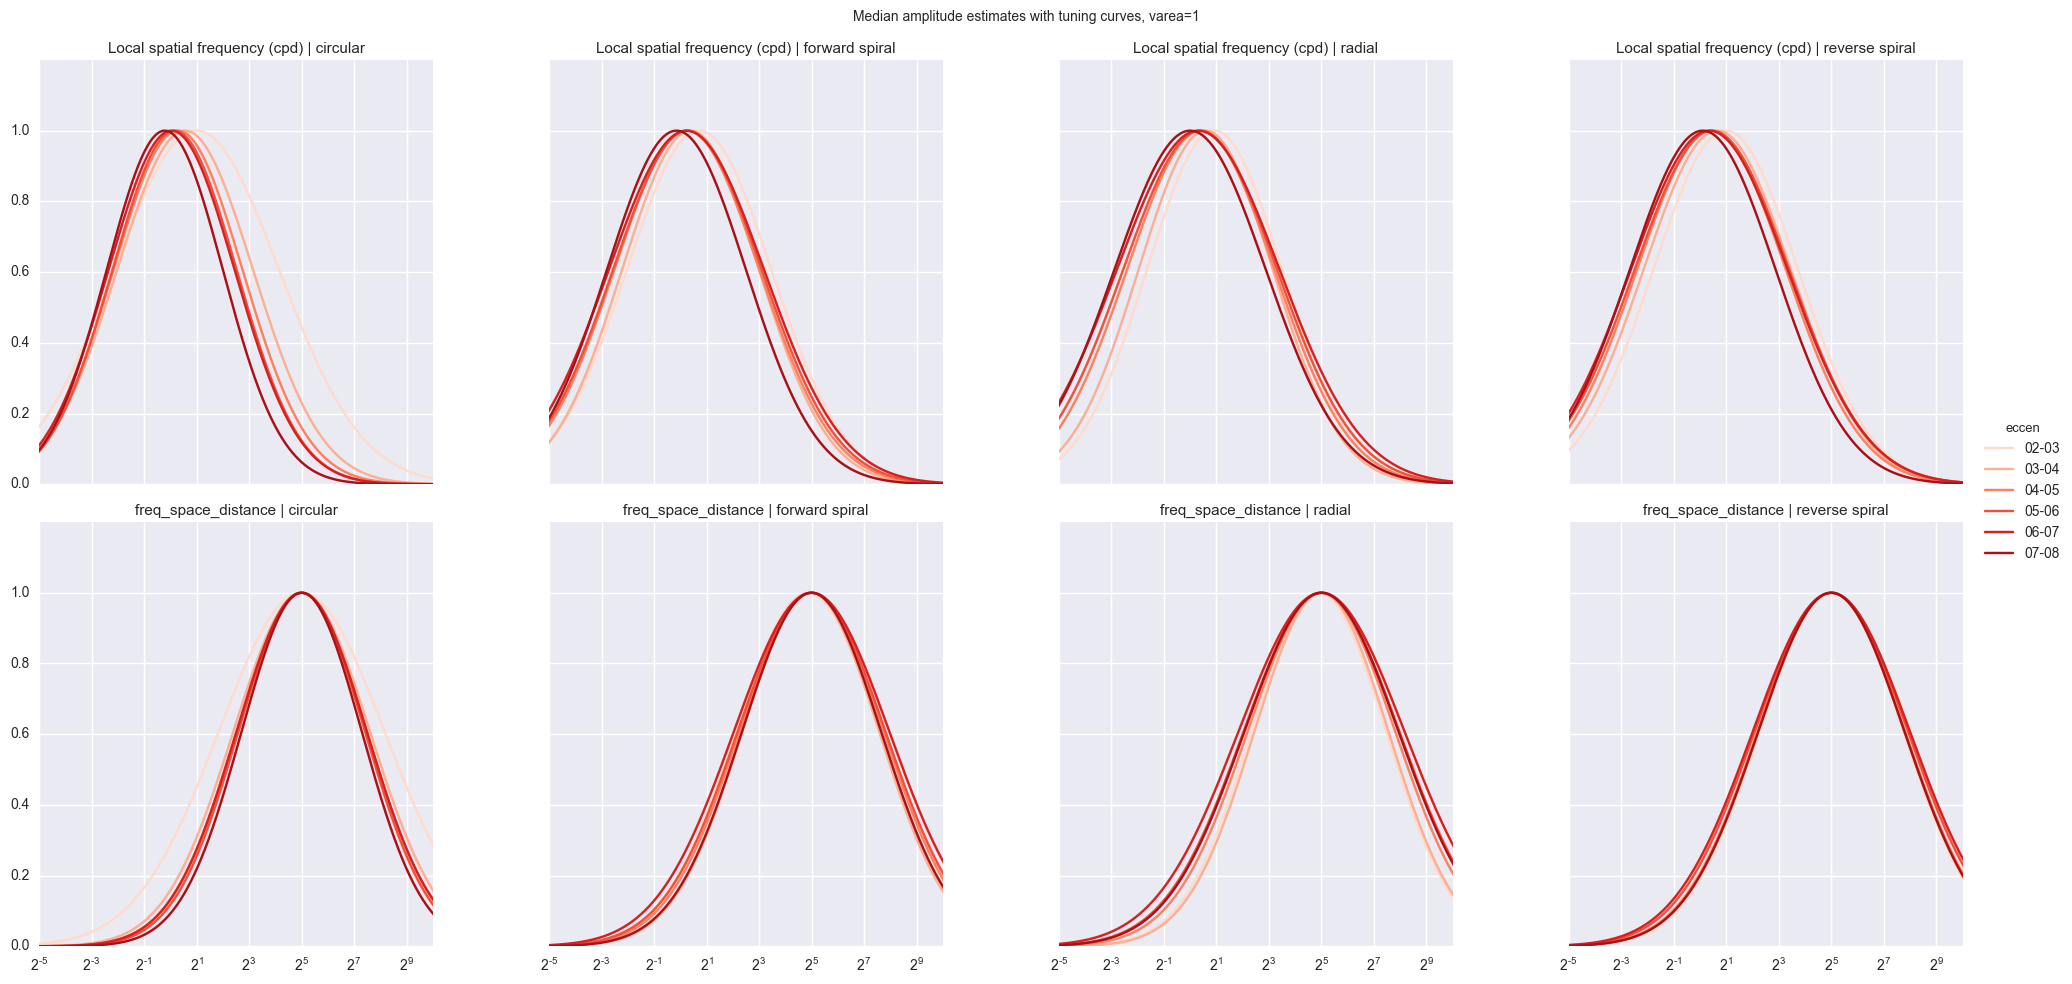

In [4]:
sfp.plotting.check_hypotheses_normalized(ds['tuning_df'], 'test_%s.svg')

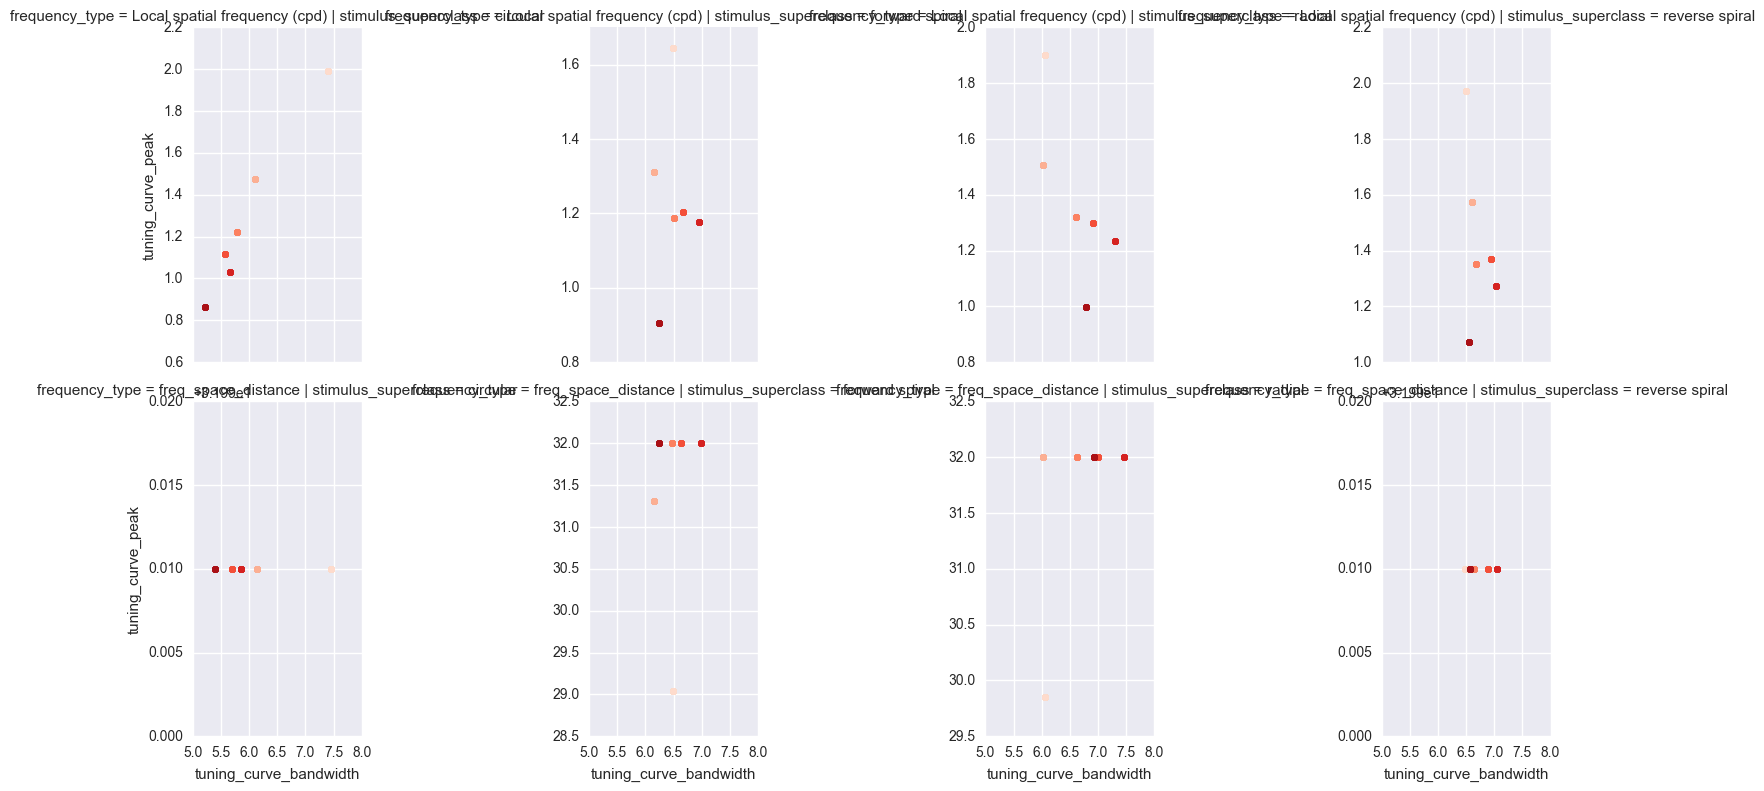

In [10]:
g=sns.FacetGrid(ds['tuning_df'], hue='eccen', row='frequency_type', palette='Reds', col='stimulus_superclass', sharey=False, size=4)
g.map(sns.plt.scatter, 'tuning_curve_bandwidth','tuning_curve_peak')


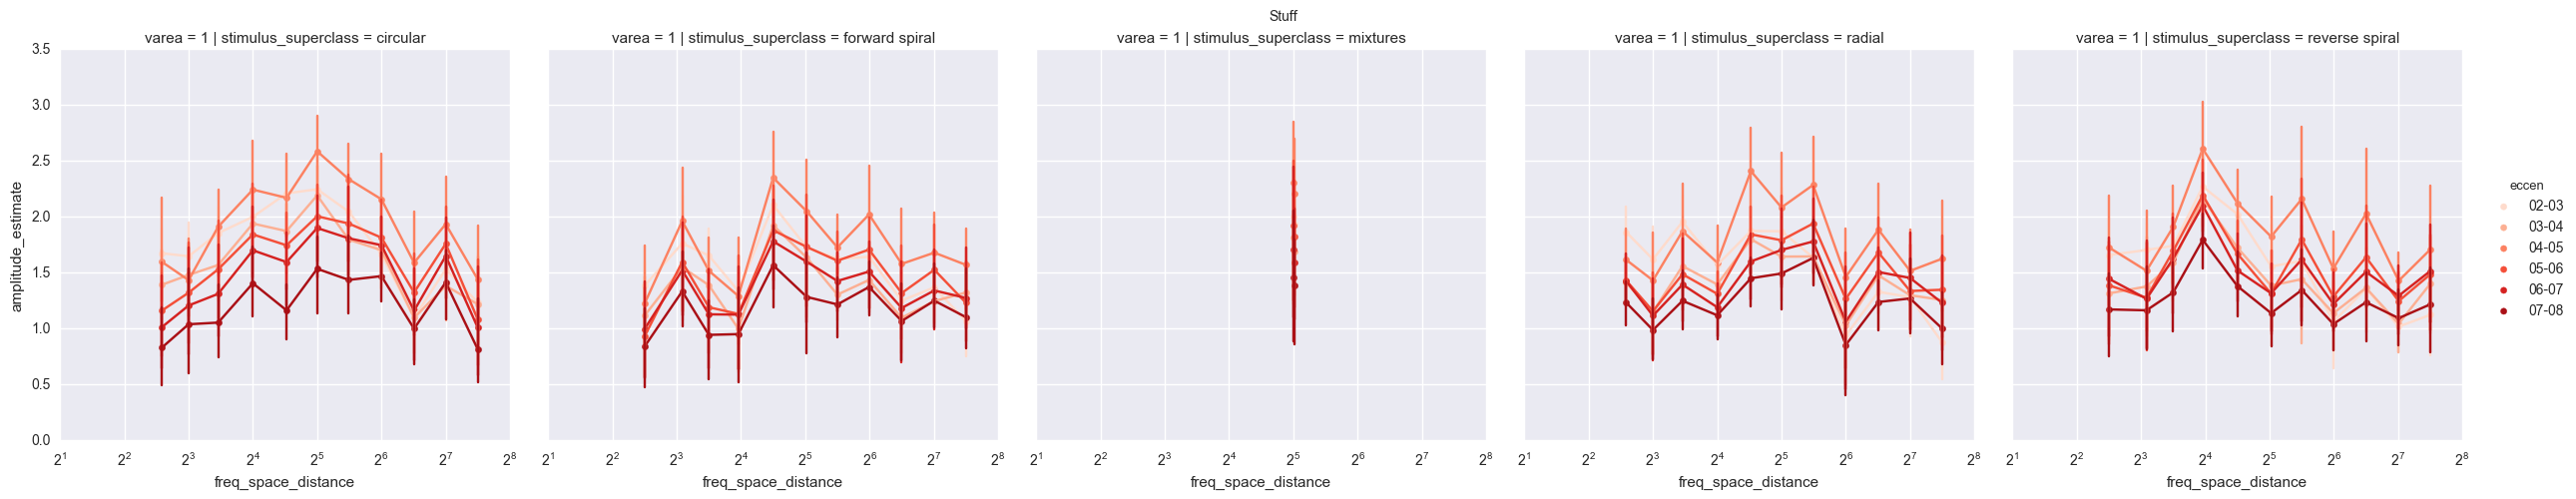

In [104]:
plot_data(d['df'], 'freq_space_distance',)# ci_vals=[16, 84])

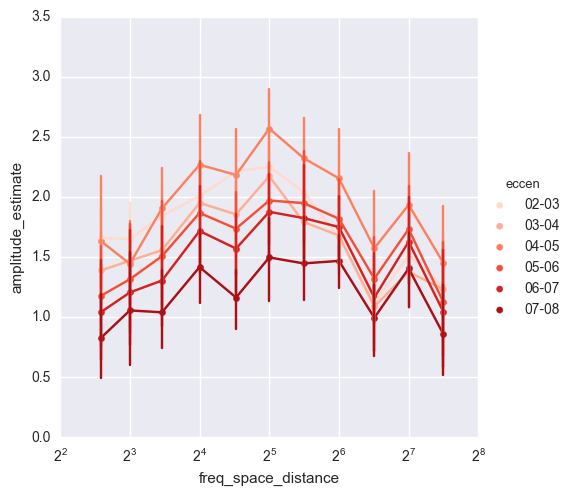

In [6]:
tmp_df = d['df'][d['df'].stimulus_superclass=='circular']
g = sns.FacetGrid(tmp_df, hue='eccen', palette='Reds', size=5,)
#g.map(sns.regplot, 'rounded_freq_space_distance', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'rounded_freq_space_distance', 'amplitude_estimate')
g.map_dataframe(sfp.utils.scatter_ci_dist, 'freq_space_distance', 'amplitude_estimate')
for ax in g.axes.flatten():
    ax.set_xscale('log', basex=2)
g.add_legend()

If there were no scaling in the visual system, such that neurons at different places in the visual field were expected to have similar properties, the bottom would all line up well, and it doesn't!


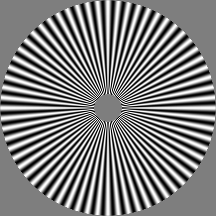
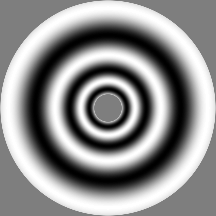
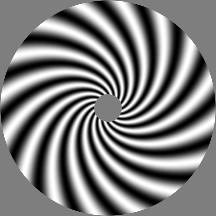
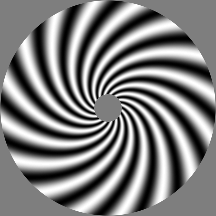

In [17]:
classes_of_interest = []
classes_of_interest.extend(df[(df.stimulus_superclass=='circular')&(df.rounded_freq_space_distance==11)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='radial')&(df.rounded_freq_space_distance==64)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='forward spiral')&(df.rounded_freq_space_distance==23)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='reverse spiral')&(df.rounded_freq_space_distance==23)].stimulus_class.unique())
#classes_of_interest.append(df[df.stimulus_superclass=='mixtures'].stimulus_class.values[0])

stim_idxs = stim_df[stim_df.class_idx.isin(classes_of_interest)].index.values[::8]

jbh.showIm([stim[i, :, :] for i in stim_idxs], ncols=4, zoom=.2)

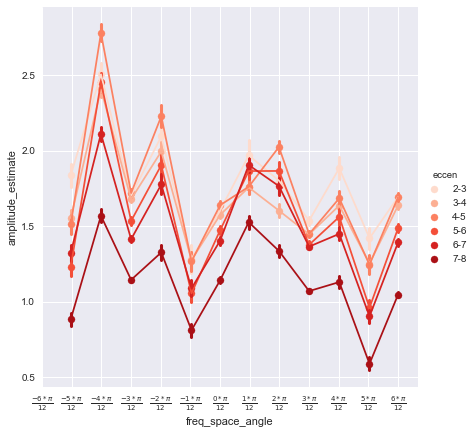

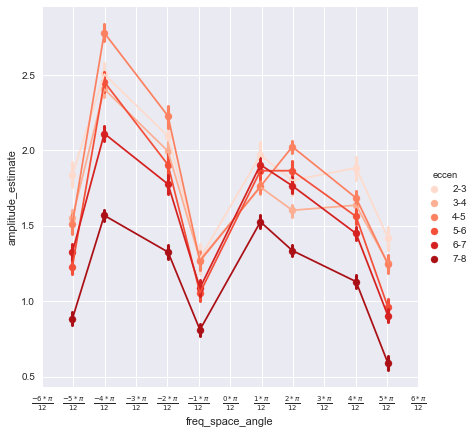

In [52]:
# I know this goes from about -pi/2 to pi/2, in pi/12 steps
ticks = [(np.pi*(i-6)/12.) for i in range(13)]
labels = ['$\\frac{%s*\\pi}{12}$'%(i-6) for i in range(13)]

g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=6)
g.map(sns.regplot, 'freq_space_angle', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_angle', 'amplitude_estimate')
#g.map_dataframe(sfp.utils.scatter_ci, 'freq_space_angle', 'amplitude_estimate_median', 'amplitude_estimate_std_error') 
_=g.ax.set_xticks(ticks)
_=g.ax.set_xticklabels(labels)
g.add_legend()

# I know this goes from about -pi/2 to pi/2, in pi/12 steps
ticks = [(np.pi*(i-6)/12.) for i in range(13)]
labels = ['$\\frac{%s*\\pi}{12}$'%(i-6) for i in range(13)]

tmp_df = df[df.stimulus_superclass=='mixtures']
g = sns.FacetGrid(tmp_df, hue='eccen', palette='Reds', size=6)
g.map(sns.regplot, 'freq_space_angle', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_angle', 'amplitude_estimate')
#g.map_dataframe(sfp.utils.scatter_ci, 'freq_space_angle', 'amplitude_estimate_median', 'amplitude_estimate_std_error') 
_=g.ax.set_xticks(ticks)
_=g.ax.set_xticklabels(labels)
g.add_legend()


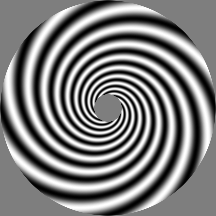
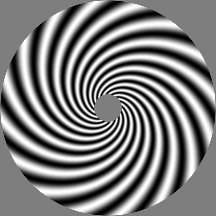
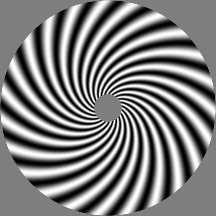
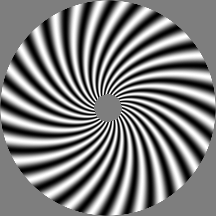
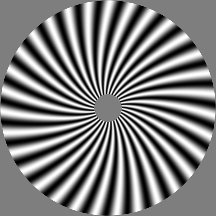
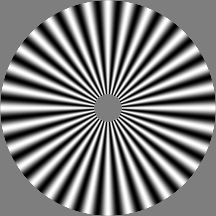
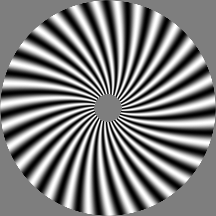
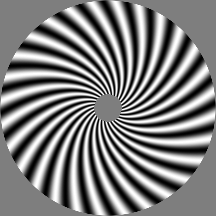
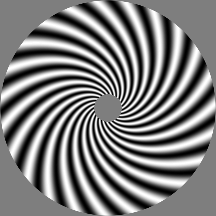
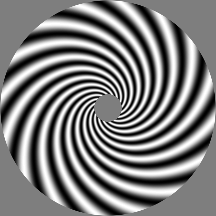
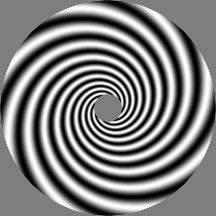
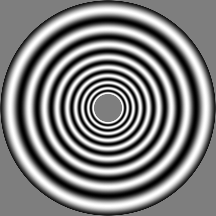

In [85]:
angles = sorted(df.freq_space_angle.unique())
stim_idxs = []
for ang in angles:
    class_of_interest = df[(df.freq_space_angle==ang)&(df.rounded_freq_space_distance==32)].stimulus_class.unique()[0]
    stim_idxs.append(stim_df[stim_df.class_idx==class_of_interest].index[0])

#stim_idxs = stim_df[stim_df.class_idx.isin(classes_of_interest)].index.values[::8]

jbh.showIm([stim[i, :, :] for i in stim_idxs], ncols=4, zoom=.2)

/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


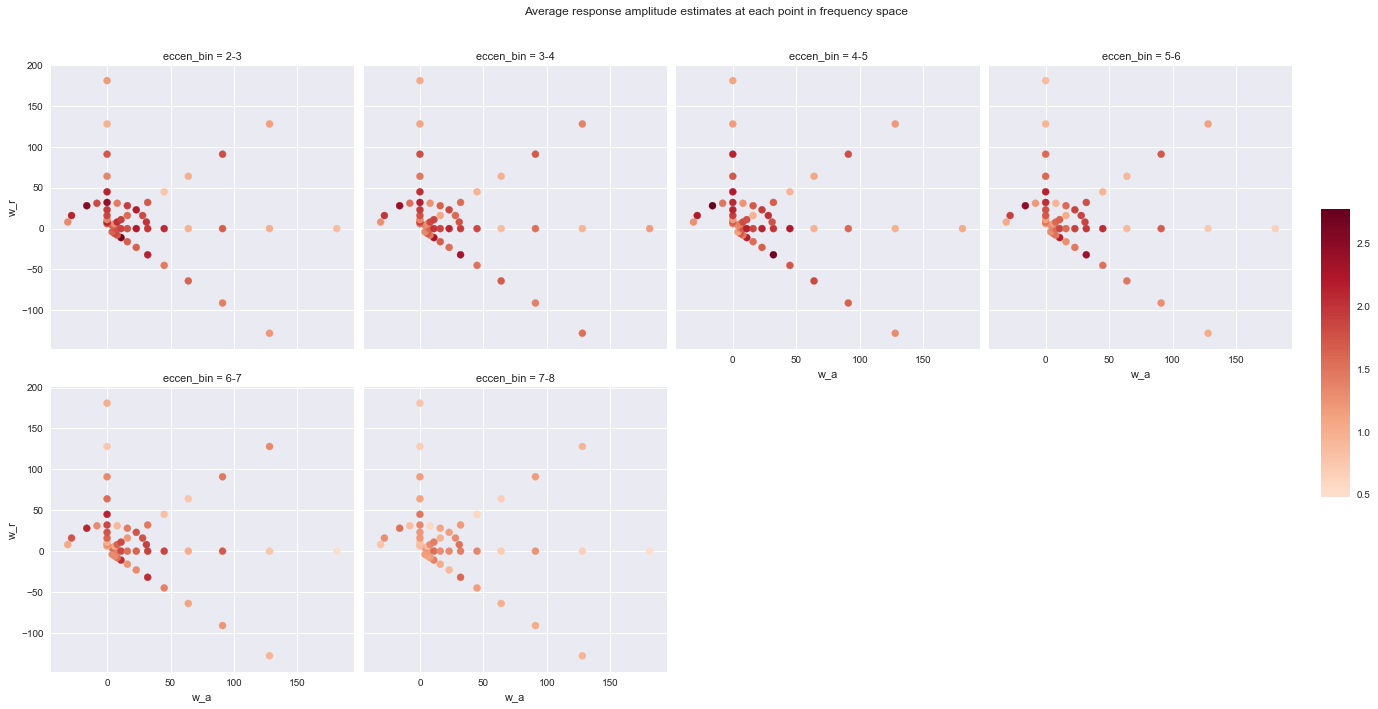

In [16]:
tmp_df = pd.DataFrame(df.groupby(['eccen_bin', 'w_r', 'w_a']).modelmd.mean()).reset_index()

g = sns.FacetGrid(tmp_df, col='eccen_bin', col_wrap=4, size=5)
cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes
g.map(sfp.utils.scatter_heat, 'w_a', 'w_r', 'amplitude_estimate_median', vmin=tmp_df['amplitude_estimate_median'].min(), 
      vmax=tmp_df['amplitude_estimate_median'].max())
sns.plt.colorbar(cax=cbar_ax)
g.fig.subplots_adjust(right=.9, top=.9)
g.fig.suptitle('Average response amplitude estimates at each point in frequency space')

In [17]:
tmp_df = pd.pivot_table(df, 'amplitude_estimate_median', 'rounded_freq_space_distance', 'eccen_bin')
norm_df = tmp_df.copy()
for col in norm_df.columns:
    norm_df[col] = norm_df[col] / norm_df[col].max()

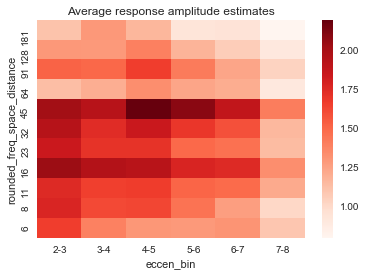

In [80]:
fig = sns.heatmap(tmp_df, cmap='Reds')
fig.invert_yaxis()
fig.set_title('Average response amplitude estimates')

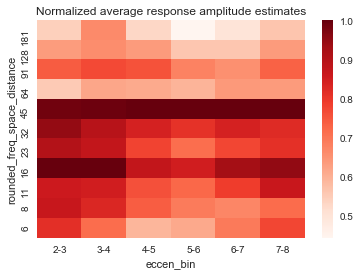

In [81]:
fig = sns.heatmap(norm_df, cmap='Reds')
fig.invert_yaxis()
fig.set_title('Normalized average response amplitude estimates')

In [11]:
df = pd.read_csv('/home/billbrod/Data/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/prior/sub-wlsubj001/ses-pilot01/sub-wlsubj001_ses-pilot01_task-sfp_summary_v1_e2-8_eccen_bin_hemi_bin.csv')

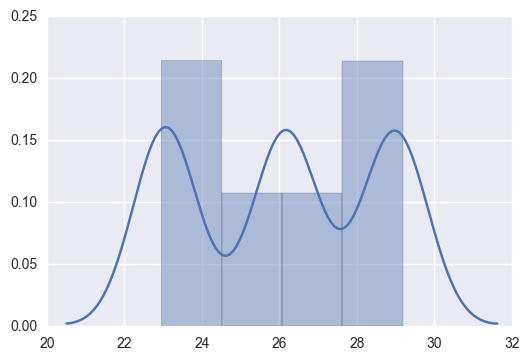

In [12]:
sns.distplot(df.R2.values)

# Create plots for first year talk

In [50]:
# for this, we're only using circular results
tmp_df = df[df.stimulus_superclass=='circular']
# tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num', 'hemi']]
tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num']]

In [51]:
tmper_df = tmp_df[tmp_df.freq_space_distance==6.]
tmper_df = tmper_df.groupby(['eccen', 'bootstrap_num'])['amplitude_estimate'].mean().unstack().reset_index()

In [52]:
hyp_df = pd.melt(tmp_df, ['eccen', 'amplitude_estimate', 'bootstrap_num'], var_name='Frequency')
hyp_df = pd.DataFrame(hyp_df.groupby(['Frequency', 'value', 'bootstrap_num'])['amplitude_estimate'].mean()).reset_index()

In [3]:
#print("freq_space_distance min: %.03f, max: %.03f" % (tmp_df.freq_space_distance.min(), tmp_df.freq_space_distance.max()))
#print("Halfway in log space: %.03f" % np.floor(2**((np.log2(181.) + np.log2(6.))/2.)))
# because these are circular, freq_space_distance==w_r
#stim_idx = stim_df[(stim_df.w_r.isin([6, 32, 181]))&(stim_df.w_a==0)].index[::8]
stim_idx = d['stim_df'][(d['stim_df'].w_r.isin([6, 32, ]))&(d['stim_df'].w_a==0)].index[::8]
stims = [d['stim'][i] for i in stim_idx]

We actually want to plot windows of the stimuli instead of just sins

In [4]:
max_degree_rad = 12
scale_factor = 10
mask = sfp.utils.create_circle_mask(750, 350, scale_factor* 1080/(2*2*max_degree_rad), 1080)
stim_windows = [mask * s + ~mask.astype(bool)*127 for s in stims]


NameError: name 'stims' is not defined

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

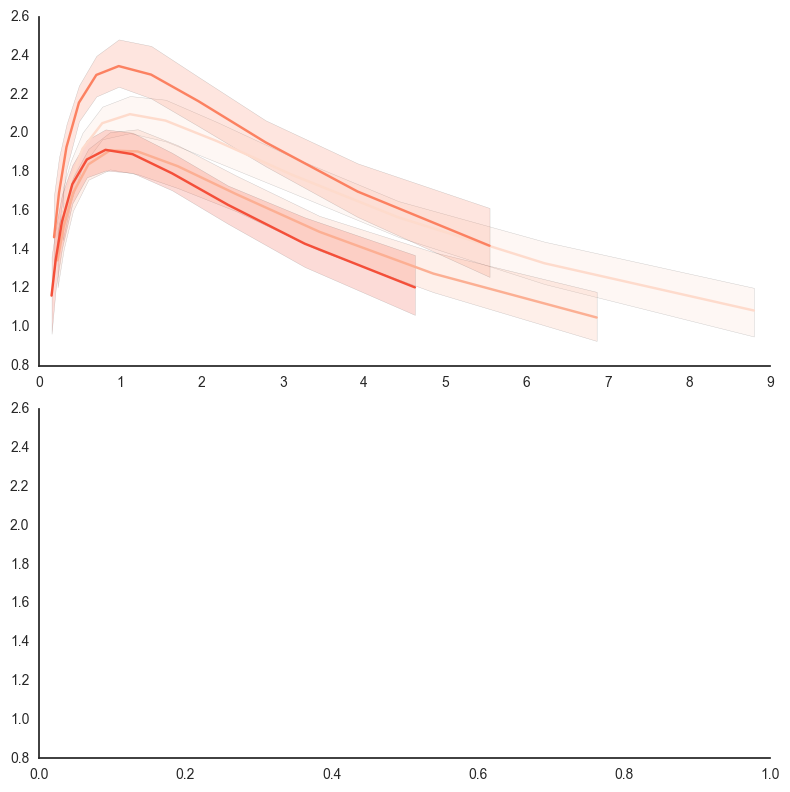

In [3]:
tmp_df = d['df']
tmp_df = tmp_df[(tmp_df.stimulus_superclass=='circular')&(tmp_df.eccen.isin(['02-03', '03-04', '04-05', '05-06', '06-07', '07-08']))]#&(tmp_df.bootstrap_num.isin(range(5)))]
sfp.plotting.compare_hypotheses(tmp_df)

../sfp/utils.py:234: UserWarning: The following bootstrap was not well fit by a log Gaussian and so is skipped:
eccen                                          03-04
bootstrap_num                                      0
stimulus_superclass                   forward spiral
Frequency              Local spatial frequency (cpd)
Name: 1895, dtype: object
  " skipped:\n%s" % data.iloc[0][idx])
../sfp/utils.py:234: UserWarning: The following bootstrap was not well fit by a log Gaussian and so is skipped:
eccen                                          07-08
bootstrap_num                                      0
stimulus_superclass                   forward spiral
Frequency              Local spatial frequency (cpd)
Name: 1915, dtype: object
  " skipped:\n%s" % data.iloc[0][idx])
../sfp/utils.py:234: UserWarning: The following bootstrap was not well fit by a log Gaussian and so is skipped:
eccen                                          02-03
bootstrap_num                                      0
stim

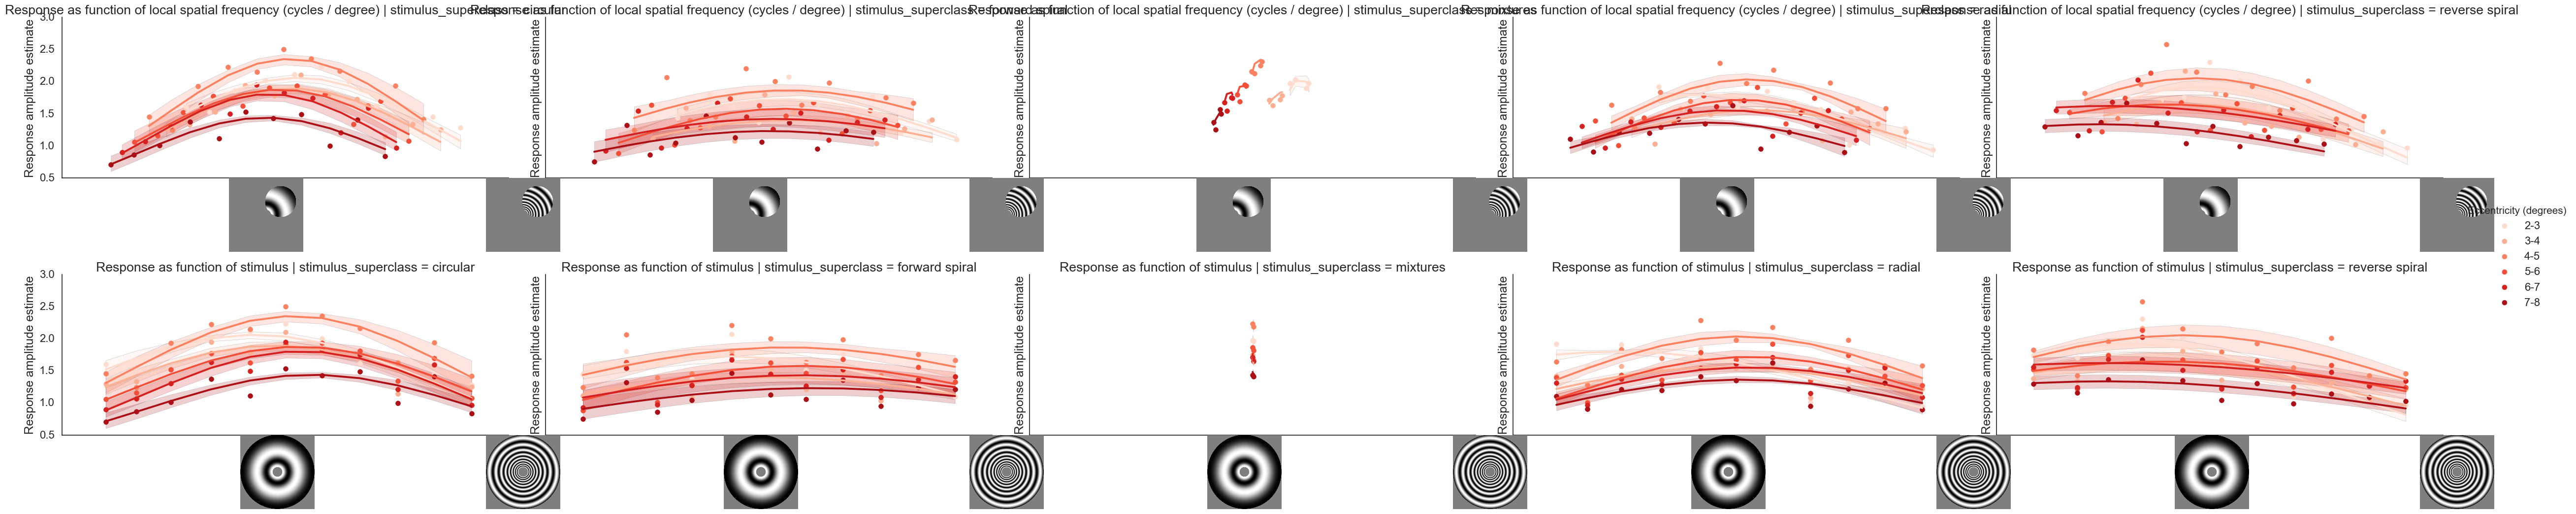

In [6]:
tmp_df = d['df']
tmp_df = tmp_df[(tmp_df.bootstrap_num.isin(range(5)))]
sfp.plotting.compare_hypotheses_talk(tmp_df, stims)

In [13]:
# for this, we're only using circular results
tmp_df = d['df'][d['df'].stimulus_superclass.isin(['circular'])]
# tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num', 'hemi']]
tmp_df = tmp_df[['stimulus_superclass','eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num']]
tmp_df = tmp_df[tmp_df.bootstrap_num.isin(range(5))]

peak_df = sfp.plotting.peak_spatial_frequency(tmp_df, id_vars=['stimulus_superclass'])

In [14]:
speak_df

bandwidth  eccen      peak stimulus_superclass  peak_hyperbola_param
03  361124.332517    2.5  1.163916            circular              0.259305
04  136066.843456    3.5  1.085951            circular              0.259305
05   38515.227255    4.5  1.060452            circular              0.259305
06   57147.822236    5.5  0.926438            circular              0.259305
07    6983.125012    6.5  0.814249            circular              0.259305
08   22036.688090    7.5  0.783039            circular              0.259305

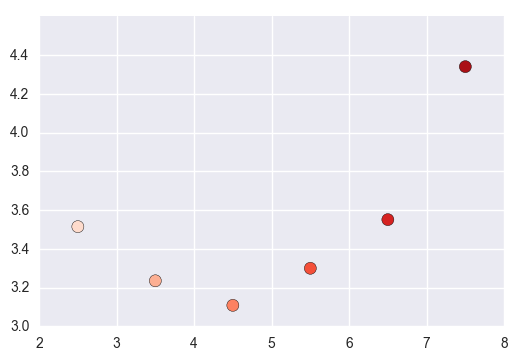

In [30]:
sns.plt.scatter(bandwidth[:,0], bandwidth[:,1], c=sns.color_palette('Reds', 6), s=75)

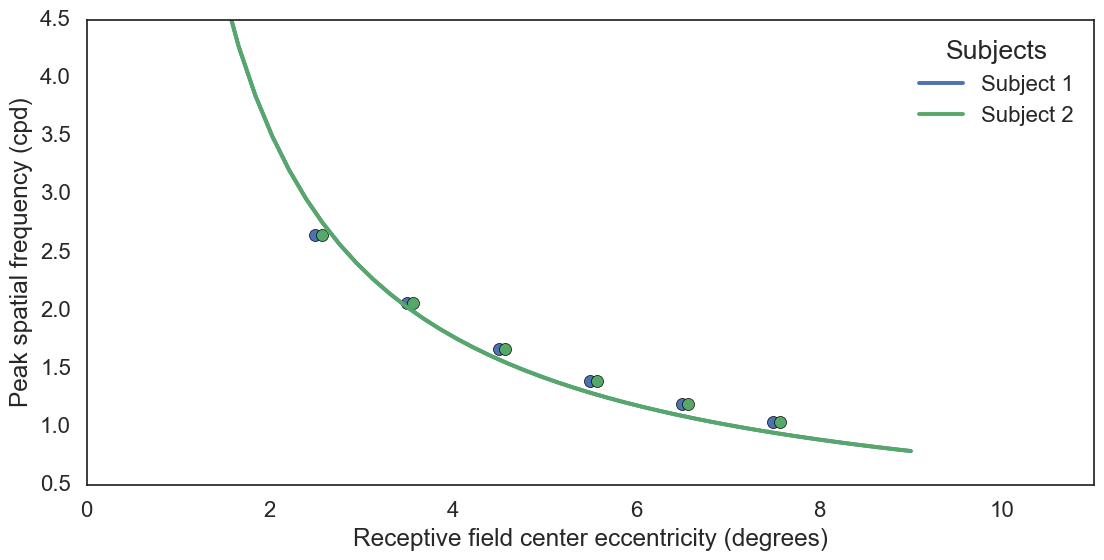

In [124]:
ecc = np.linspace(.01, 9, 50)
RF_scale_factor = 4.
V1_RF_size = np.concatenate([np.ones(len(ecc[ecc<.5]))/RF_scale_factor, np.linspace(1/RF_scale_factor, 4/RF_scale_factor, len(ecc[ecc>=.5]))])
#V2_RF_size = np.concatenate([2*np.ones(len(ecc[ecc<4])), np.linspace(2, 2.5, len(ecc[ecc>=4]))])

Olsson_peak = [2.75, 2.11, 1.76, 1.47,1.24, 1.06, .88, .77, .66, .60]
Olsson_ecc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

with sns.plotting_context('poster', font_scale=1), sns.axes_style('white'):
    # because this doesn't represent data, just intuition, we use this.
#    with plt.xkcd():
    x = np.linspace(.01, 9, 50)
    y = []
    fig, axes = sns.plt.subplots(1,1, figsize=(13,6))
    ax = axes
    # this gives intuitive plots, currently we want the possible hypotheses instead
#         for i in range(3):
#             y.append(10/(x+2)+i)
#             ax.plot(x, y[-1],  label='V%s'%(i+1), color=['r','g','b'][i])
    colors = sns.color_palette(n_colors=3)
    for i, (p, o) in enumerate([[peak_01_s0, opt_a_01_s0], [peak_01, opt_a_01]]):#, [peak_45, opt_a_45]]):
#    ax.plot(ecc, hyperbola(ecc, opt_a), '-', label='scaling')
#        ax.plot(ecc, hyperbola(ecc, o), '-', label='scaling', c= colors[i])
        ax.plot(ecc, hyperbola(ecc, o), '-', label='Subject %s'%(i+1), c= colors[i])
#    ax.plot(ecc, np.ones(len(ecc))*RF_scale_factor, '--', label='constant')
#        ax.set_ylim((0,8))
#    sns.plt.scatter(peak[:, 0], peak[:, 1], c=sns.color_palette('Reds', 6), s=75,)# label='This study')
        if i==1:
            sns.plt.scatter(p[:, 0]+.07, p[:, 1], c=colors[i], s=75,)# label='This study')
        else:
            sns.plt.scatter(p[:, 0], p[:, 1], c=colors[i], s=75,)# label='This study')
#    sns.plt.scatter(Olsson_ecc, Olsson_peak, s=75, c= sns.color_palette('Blues', 10), label='Olsson pilot')
    ax.set_xlabel("Receptive field center eccentricity (degrees)")
    ax.set_ylabel("Peak spatial frequency (cpd)")
    ax.set_title("")
    ax.set_ylim((.5, 4.5))
    ax.set_xlim((0, 11))

    sns.plt.legend(title="Subjects", loc='best')
#    ax.figure.savefig('results-hypotheses.svg', bbox_inches='tight')